# Import the libraries

In [56]:
# For handling the data
import pandas as pd
import numpy as np

# For Visualizing the data
import matplotlib.pyplot as plt
import seaborn as sns

# For Training the model
from sklearn.datasets import fetch_openml
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score , cross_val_predict , StratifiedKFold
from sklearn.metrics import confusion_matrix , classification_report , precision_score, recall_score , f1_score , precision_recall_curve

# Get the Data and split them

In [24]:
mnist = fetch_openml('mnist_784', as_frame=False)

In [25]:
X , y = mnist.data , mnist.target
mnist.DESCR

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [26]:
X_train , X_test , y_train , y_test = X[:60000] , X[60000:] , y[:60000] , y[60000:]

# Take a Look at the Data

In [27]:
 #each image has 784 feature,each image is 28x28 pixels, each feature represent one pixel
X.shape

(70000, 784)

In [28]:
y.shape

(70000,)

In [29]:
def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image , cmap="binary")
    plt.axis("off")

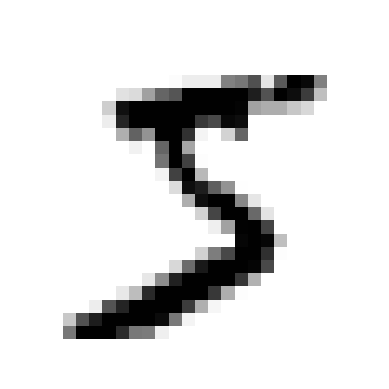

In [30]:
some_digit = X[0]
plot_digit(some_digit)
plt.show()

# Training a Binary Classifier

In [31]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')
y_train_5 # if the  digit is 5 true otherwise false

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In [32]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5) # now the model has learned to distinguish 5s from non-5s.

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [33]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

#### Measuring Accuracy Using Cross-Validation

In [34]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3 , scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [35]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [36]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

##### Implementing Cross-Validation From scratch

In [37]:
skfolds = StratifiedKFold(n_splits=3)
for train_index , test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


#### Confusion Matrices

In [38]:
y_train_pred = cross_val_predict(sgd_clf , X_train, y_train_5 , cv = 3)
confusionMatrix = confusion_matrix(y_train_5 , y_train_pred)

In [39]:
confusionMatrix

array([[53892,   687],
       [ 1891,  3530]])

In [40]:
precision_score(y_train_5, y_train_pred) # from the detected 5's only 83% were right

0.8370879772350012

In [41]:
recall_score(y_train_5, y_train_pred) # from all the 5's we only detected 65%

0.6511713705958311

In [43]:
f1_score(y_train_5, y_train_pred)

0.7325171197343847

#### The Precision / Recall Trade-off

In [44]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [51]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [53]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [54]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

In [55]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447], shape=(60000,))

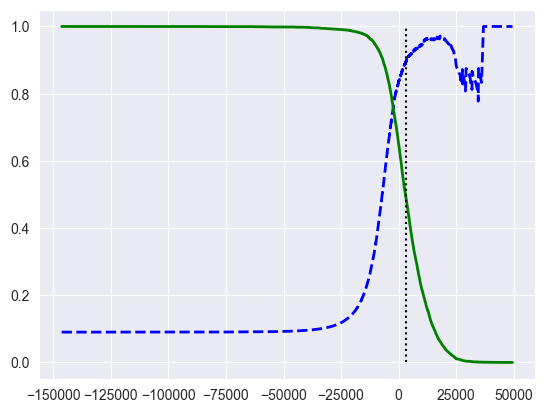

In [57]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")